# GNN Explainer Analysis

This notebook analyzes the outputs from GNNExplainer and PAGE explainers.

## Data Files
- `data/05_model_explanations/selected_triples.pkl` - The triples selected for explanation
- `data/05_model_explanations/gnn_explanations.pkl` - GNNExplainer results
- `data/05_model_explanations/page_explanations.pkl` - PAGE explainer results

In [1]:
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set paths
DATA_DIR = Path('../data/05_model_explanations')

print(f'Data directory: {DATA_DIR}')
print(f'Files available: {list(DATA_DIR.glob("*.pkl"))}')

Data directory: ../data/05_model_explanations
Files available: [PosixPath('../data/05_model_explanations/selected_triples.pkl'), PosixPath('../data/05_model_explanations/gnn_explanations.pkl'), PosixPath('../data/05_model_explanations/page_explanations.pkl')]


## 1. Load Selected Triples

In [2]:
# Load selected triples (with CPU mapping for CUDA tensors)
import functools
import io

class CPU_Unpickler(pickle.Unpickler):
    """Custom unpickler that maps CUDA tensors to CPU."""
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu', weights_only=False)
        else:
            return super().find_class(module, name)

def load_pickle_cpu(file_path):
    """Load pickle file with CUDA tensors mapped to CPU."""
    with open(file_path, 'rb') as f:
        return CPU_Unpickler(f).load()

selected_triples = load_pickle_cpu(DATA_DIR / 'selected_triples.pkl')

print('Selected Triples Structure:')
print(f'  Keys: {selected_triples.keys()}')
print(f'  Number of triples: {selected_triples["num_selected"]}')
print(f'  Source: {"from_file" if selected_triples.get("from_file") else "random"}')
print(f'  File path: {selected_triples.get("file_path", "N/A")}')

Selected Triples Structure:
  Keys: dict_keys(['selected_indices', 'selected_edge_index', 'selected_edge_type', 'triples_readable', 'num_selected', 'from_test_set'])
  Number of triples: 10
  Source: random
  File path: N/A


In [3]:
# Display triples as DataFrame
triples_df = pd.DataFrame(selected_triples['triples_readable'])
triples_df

,head_idx,tail_idx,relation_idx,head_name,tail_name,relation_name,triple
0,13353,150475,50,CHEBI:135702,MONDO:0008170,predicate:38,"(CHEBI:135702, predicate:38, MONDO:0008170)"
1,13487,152767,50,CHEBI:135929,MONDO:0010811,predicate:38,"(CHEBI:135929, predicate:38, MONDO:0010811)"
2,63354,862476,50,CHEBI:82405,UMLS:C0033775,predicate:38,"(CHEBI:82405, predicate:38, UMLS:C0033775)"
3,20259,163862,50,CHEBI:16526,MONDO:0850093,predicate:38,"(CHEBI:16526, predicate:38, MONDO:0850093)"
4,44406,153702,50,CHEBI:44423,MONDO:0011996,predicate:38,"(CHEBI:44423, predicate:38, MONDO:0011996)"
5,50268,141504,50,CHEBI:5855,HP:0100607,predicate:38,"(CHEBI:5855, predicate:38, HP:0100607)"
6,48881,147624,50,CHEBI:53749,MONDO:0004652,predicate:38,"(CHEBI:53749, predicate:38, MONDO:0004652)"
7,62486,145531,50,CHEBI:7983,MONDO:0002125,predicate:38,"(CHEBI:7983, predicate:38, MONDO:0002125)"
8,65492,147959,50,CHEBI:85994,MONDO:0005086,predicate:38,"(CHEBI:85994, predicate:38, MONDO:0005086)"
9,13501,138541,50,CHEBI:135947,HP:0031217,predicate:38,"(CHEBI:135947, predicate:38, HP:0031217)"


## 2. Load and Analyze GNNExplainer Results

In [4]:
# Load GNN explanations (using CPU unpickler)
gnn_exp = load_pickle_cpu(DATA_DIR / 'gnn_explanations.pkl')

print('GNNExplainer Results:')
print(f'  Explainer type: {gnn_exp["explainer_type"]}')
print(f'  Num explanations: {gnn_exp["num_explanations"]}')
print(f'  Parameters: {gnn_exp["params"]}')

GNNExplainer Results:
  Explainer type: GNNExplainer
  Num explanations: 10
  Parameters: {'gnn_epochs': 200, 'gnn_lr': 0.01, 'top_k_edges': 10, 'subgraph_method': 'paths', 'khop_distance': 2, 'max_path_length': 3}


In [5]:
# Check for errors in GNNExplainer results
gnn_results = []
for i, exp in enumerate(gnn_exp['explanations']):
    result = {
        'idx': i,
        'triple': exp['triple']['triple'],
        'has_error': 'error' in exp,
        'error': exp.get('error', None),
        'error_type': exp.get('error_type', None)
    }
    gnn_results.append(result)

gnn_results_df = pd.DataFrame(gnn_results)
print(f'Successful explanations: {(~gnn_results_df["has_error"]).sum()}/{len(gnn_results_df)}')
print(f'Failed explanations: {gnn_results_df["has_error"].sum()}/{len(gnn_results_df)}')
gnn_results_df

Successful explanations: 10/10
Failed explanations: 0/10


,idx,triple,has_error,error,error_type
0,0,"(CHEBI:135702, predicate:38, MONDO:0008170)",False,None,None
1,1,"(CHEBI:135929, predicate:38, MONDO:0010811)",False,None,None
2,2,"(CHEBI:82405, predicate:38, UMLS:C0033775)",False,None,None
3,3,"(CHEBI:16526, predicate:38, MONDO:0850093)",False,None,None
4,4,"(CHEBI:44423, predicate:38, MONDO:0011996)",False,None,None
5,5,"(CHEBI:5855, predicate:38, HP:0100607)",False,None,None
6,6,"(CHEBI:53749, predicate:38, MONDO:0004652)",False,None,None
7,7,"(CHEBI:7983, predicate:38, MONDO:0002125)",False,None,None
8,8,"(CHEBI:85994, predicate:38, MONDO:0005086)",False,None,None
9,9,"(CHEBI:135947, predicate:38, HP:0031217)",False,None,None


In [6]:
# If there are successful explanations, analyze them
successful_gnn = [exp for exp in gnn_exp['explanations'] if 'error' not in exp]

if successful_gnn:
    print(f'Analyzing {len(successful_gnn)} successful GNNExplainer results...')
    print()
    print('Structure of successful explanation:')
    for k, v in successful_gnn[0].items():
        if hasattr(v, 'shape'):
            print(f'  {k}: shape={v.shape}, dtype={v.dtype}')
        elif isinstance(v, dict):
            print(f'  {k}: dict with keys {list(v.keys())}')
        else:
            print(f'  {k}: {type(v).__name__}')
else:
    print('No successful GNNExplainer results to analyze.')
    print('All explanations failed with error:', gnn_exp['explanations'][0].get('error'))

Analyzing 10 successful GNNExplainer results...

Structure of successful explanation:
  triple: dict with keys ['head_idx', 'tail_idx', 'relation_idx', 'head_name', 'tail_name', 'relation_name', 'triple']
  explanation: Explanation
  edge_mask: shape=torch.Size([16694]), dtype=torch.float32
  important_edges: shape=torch.Size([2, 10]), dtype=torch.int64
  important_edge_types: shape=torch.Size([10]), dtype=torch.int64
  importance_scores: shape=torch.Size([10]), dtype=torch.float32
  subgraph_size: int


## 3. Load and Analyze PAGE Explainer Results

In [7]:
# Load PAGE explanations (using CPU unpickler)
page_exp = load_pickle_cpu(DATA_DIR / 'page_explanations.pkl')

print('PAGE Explainer Results:')
print(f'  Explainer type: {page_exp["explainer_type"]}')
print(f'  Num explanations: {page_exp["num_explanations"]}')
print(f'  Model aware: {page_exp.get("model_aware", "N/A")}')
print(f'  Uses encoder: {page_exp.get("uses_encoder", "N/A")}')
print(f'  Uses decoder: {page_exp.get("uses_decoder", "N/A")}')
print()
print('Parameters:')
for k, v in page_exp['params'].items():
    print(f'  {k}: {v}')

PAGE Explainer Results:
  Explainer type: ImprovedPAGE
  Num explanations: 10
  Model aware: True
  Uses encoder: True
  Uses decoder: True

Parameters:
  train_epochs: 100
  lr: 0.003
  k_hops: 2
  subgraph_method: paths
  max_path_length: 3
  encoder_hidden1: 32
  encoder_hidden2: 16
  latent_dim: 16
  decoder_hidden1: 16
  decoder_hidden2: 16
  dropout: 0.0
  kl_weight: 0.2
  prediction_weight: 1.0
  top_k_edges: 100
  checkpoint_interval: 10
  checkpoint_dir: data/06_explainer_cache
  force_retrain: False
  force_reextract: False


In [8]:
# Analyze PAGE explanation structure
exp = page_exp['explanations'][0]
print('PAGE Explanation Structure:')
print(f'  Keys: {list(exp.keys())}')
print()
for k, v in exp.items():
    if hasattr(v, 'shape'):
        print(f'  {k}: tensor shape={v.shape}, dtype={v.dtype}')
    elif isinstance(v, dict):
        print(f'  {k}: dict with {len(v)} keys: {list(v.keys())}')
    else:
        print(f'  {k}: {type(v).__name__} = {v}')

PAGE Explanation Structure:
  Keys: ['triple', 'edge_importance_matrix', 'important_edges', 'important_edge_types', 'importance_scores', 'subgraph_info', 'latent_representation', 'prediction_score']

  triple: dict with 7 keys: ['head_idx', 'tail_idx', 'relation_idx', 'head_name', 'tail_name', 'relation_name', 'triple']
  edge_importance_matrix: tensor shape=torch.Size([1051, 1051]), dtype=torch.float32
  important_edges: tensor shape=torch.Size([2, 100]), dtype=torch.int64
  important_edge_types: tensor shape=torch.Size([100]), dtype=torch.int64
  importance_scores: tensor shape=torch.Size([100]), dtype=torch.float32
  subgraph_info: dict with 6 keys: ['triple_idx', 'num_nodes', 'num_edges', 'subgraph_nodes', 'subgraph_edges', 'prediction_score']
  latent_representation: tensor shape=torch.Size([1051, 16]), dtype=torch.float32
  prediction_score: float = -0.06454557925462723


In [9]:
# Create summary DataFrame for PAGE results
page_summary = []
for i, exp in enumerate(page_exp['explanations']):
    triple_info = exp['triple']
    scores = exp['importance_scores']
    subg = exp['subgraph_info']
    
    page_summary.append({
        'idx': i,
        'triple': triple_info['triple'],
        'head': triple_info['head_name'],
        'relation': triple_info['relation_name'],
        'tail': triple_info['tail_name'],
        'prediction_score': exp['prediction_score'],
        'sigmoid_score': torch.sigmoid(torch.tensor(exp['prediction_score'])).item(),
        'subgraph_nodes': subg['num_nodes'],
        'subgraph_edges': subg['num_edges'],
        'importance_min': scores.min().item(),
        'importance_max': scores.max().item(),
        'importance_mean': scores.mean().item(),
        'importance_std': scores.std().item(),
    })

page_df = pd.DataFrame(page_summary)
page_df

,idx,triple,head,relation,tail,prediction_score,sigmoid_score,subgraph_nodes,subgraph_edges,importance_min,importance_max,importance_mean,importance_std
0,0,"(CHEBI:52172, predicate:38, UMLS:C0023474)",CHEBI:52172,predicate:38,UMLS:C0023474,-0.064546,0.483869,1051,5165,1.0,1.0,1.0,0.0
1,1,"(CHEBI:2637, predicate:38, UMLS:C0085394)",CHEBI:2637,predicate:38,UMLS:C0085394,-0.145045,0.463802,441,5494,1.0,1.0,1.0,0.0
2,2,"(CHEBI:8499, predicate:38, MONDO:0005044)",CHEBI:8499,predicate:38,MONDO:0005044,41.724113,1.000000,4896,537118,1.0,1.0,1.0,0.0
3,3,"(CHEBI:194135, predicate:38, MONDO:0001797)",CHEBI:194135,predicate:38,MONDO:0001797,0.117498,0.529341,766,6393,1.0,1.0,1.0,0.0
4,4,"(CHEBI:135782, predicate:38, MONDO:0019558)",CHEBI:135782,predicate:38,MONDO:0019558,-0.290011,0.428001,176,3097,1.0,1.0,1.0,0.0
5,5,"(CHEBI:6775, predicate:38, MONDO:0005101)",CHEBI:6775,predicate:38,MONDO:0005101,15.434788,1.000000,3155,279567,1.0,1.0,1.0,0.0
6,6,"(CHEBI:3764, predicate:38, MONDO:0005984)",CHEBI:3764,predicate:38,MONDO:0005984,0.342606,0.584823,543,6551,1.0,1.0,1.0,0.0
7,7,"(CHEBI:3077, predicate:38, MONDO:0004979)",CHEBI:3077,predicate:38,MONDO:0004979,15.654333,1.000000,2836,244758,1.0,1.0,1.0,0.0
8,8,"(CHEBI:50673, predicate:38, MONDO:0004425)",CHEBI:50673,predicate:38,MONDO:0004425,3.536855,0.971718,970,76715,1.0,1.0,1.0,0.0
9,9,"(CHEBI:3139, predicate:38, MONDO:0005096)",CHEBI:3139,predicate:38,MONDO:0005096,9.634244,0.999935,2844,266600,1.0,1.0,1.0,0.0


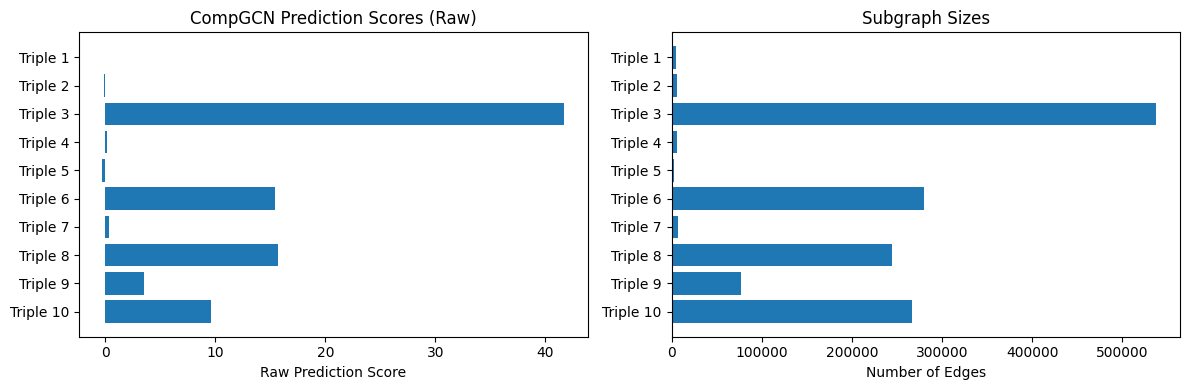

In [10]:
# Visualize prediction scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Raw scores
axes[0].barh(range(len(page_df)), page_df['prediction_score'])
axes[0].set_yticks(range(len(page_df)))
axes[0].set_yticklabels([f"Triple {i+1}" for i in range(len(page_df))])
axes[0].set_xlabel('Raw Prediction Score')
axes[0].set_title('CompGCN Prediction Scores (Raw)')
axes[0].invert_yaxis()

# Subgraph sizes
axes[1].barh(range(len(page_df)), page_df['subgraph_edges'])
axes[1].set_yticks(range(len(page_df)))
axes[1].set_yticklabels([f"Triple {i+1}" for i in range(len(page_df))])
axes[1].set_xlabel('Number of Edges')
axes[1].set_title('Subgraph Sizes')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 4. Detailed Analysis of Important Edges

In [11]:
# Load knowledge graph for node/relation name lookups (using CPU unpickler)
kg_path = Path('../data/02_intermediate/knowledge_graph.pkl')
if kg_path.exists():
    kg = load_pickle_cpu(kg_path)
    idx_to_entity = kg.get('idx_to_entity', {})
    idx_to_relation = kg.get('idx_to_relation', {})
    print(f'Loaded knowledge graph: {len(idx_to_entity)} entities, {len(idx_to_relation)} relations')
else:
    print('Knowledge graph not found. Will use node indices instead of names.')
    idx_to_entity = {}
    idx_to_relation = {}

Loaded knowledge graph: 934838 entities, 118 relations


In [12]:
def analyze_page_explanation(exp_idx, page_exp, idx_to_entity, idx_to_relation):
    """Analyze a single PAGE explanation in detail."""
    exp = page_exp['explanations'][exp_idx]
    
    triple = exp['triple']
    print(f"=== Explanation for Triple {exp_idx + 1} ===")
    print(f"Triple: {triple['triple']}")
    print(f"Head: {triple['head_name']} (idx: {triple['head_idx']})")
    print(f"Relation: {triple['relation_name']} (idx: {triple['relation_idx']})")
    print(f"Tail: {triple['tail_name']} (idx: {triple['tail_idx']})")
    print()
    
    # Prediction info
    pred = exp['prediction_score']
    print(f"Prediction score: {pred:.4f}")
    print(f"Sigmoid(score): {torch.sigmoid(torch.tensor(pred)).item():.6f}")
    print()
    
    # Subgraph info
    subg = exp['subgraph_info']
    print(f"Subgraph: {subg['num_nodes']} nodes, {subg['num_edges']} edges")
    print()
    
    # Important edges
    print("Top 10 Important Edges:")
    edges = exp['important_edges']  # [2, k] - these are GLOBAL node indices
    edge_types = exp['important_edge_types']  # [k]
    scores = exp['importance_scores']  # [k]
    
    if edges is None:
        print("  No important edges found.")
        return pd.DataFrame()
    
    edge_data = []
    for i in range(edges.shape[1]):
        # important_edges already contains GLOBAL node indices (not subgraph-local)
        src_orig = edges[0, i].item()
        dst_orig = edges[1, i].item()
        
        # Get names from knowledge graph mappings
        src_name = idx_to_entity.get(src_orig, f"node_{src_orig}")
        dst_name = idx_to_entity.get(dst_orig, f"node_{dst_orig}")
        rel_idx = edge_types[i].item()
        rel_name = idx_to_relation.get(rel_idx, f"rel_{rel_idx}")
        
        score = scores[i].item()
        
        edge_data.append({
            'rank': i + 1,
            'source': src_name,
            'source_idx': src_orig,
            'relation': rel_name,
            'target': dst_name,
            'target_idx': dst_orig,
            'importance': score
        })
        
        print(f"  {i+1}. {src_name} --[{rel_name}]--> {dst_name}  (score: {score:.6f})")
    
    return pd.DataFrame(edge_data)

# Analyze first explanation
edge_df = analyze_page_explanation(0, page_exp, idx_to_entity, idx_to_relation)

=== Explanation for Triple 1 ===
Triple: (CHEBI:52172, predicate:38, UMLS:C0023474)
Head: CHEBI:52172 (idx: 47863)
Relation: predicate:38 (idx: 50)
Tail: UMLS:C0023474 (idx: 862339)

Prediction score: -0.0645
Sigmoid(score): 0.483869

Subgraph: 1051 nodes, 5165 edges

Top 10 Important Edges:
  1. CHEBI:52172 --[predicate:0]--> HP:0001962  (score: 1.000000)
  2. CHEBI:52172 --[predicate:0]--> HP:0000505  (score: 1.000000)
  3. CHEBI:52172 --[predicate:0]--> HP:0000622  (score: 1.000000)
  4. CHEBI:52172 --[predicate:0]--> HP:0002315  (score: 1.000000)
  5. CHEBI:35610 --[predicate:0]--> CHEBI:49375  (score: 1.000000)
  6. CHEBI:52172 --[predicate:0]--> HP:0002013  (score: 1.000000)
  7. CHEBI:52172 --[predicate:0]--> HP:0001289  (score: 1.000000)
  8. CHEBI:52172 --[predicate:0]--> HP:0000958  (score: 1.000000)
  9. CHEBI:52172 --[predicate:0]--> CHEBI:35610  (score: 1.000000)
  10. CHEBI:39733 --[predicate:0]--> CHEBI:31690  (score: 1.000000)
  11. CHEBI:52172 --[predicate:0]--> HP:000

In [13]:
# Analyze all explanations
print("\n" + "="*80)
print("SUMMARY OF ALL PAGE EXPLANATIONS")
print("="*80 + "\n")

for i in range(len(page_exp['explanations'])):
    analyze_page_explanation(i, page_exp, idx_to_entity, idx_to_relation)
    print("\n" + "-"*80 + "\n")


SUMMARY OF ALL PAGE EXPLANATIONS

=== Explanation for Triple 1 ===
Triple: (CHEBI:52172, predicate:38, UMLS:C0023474)
Head: CHEBI:52172 (idx: 47863)
Relation: predicate:38 (idx: 50)
Tail: UMLS:C0023474 (idx: 862339)

Prediction score: -0.0645
Sigmoid(score): 0.483869

Subgraph: 1051 nodes, 5165 edges

Top 10 Important Edges:
  1. CHEBI:52172 --[predicate:0]--> HP:0001962  (score: 1.000000)
  2. CHEBI:52172 --[predicate:0]--> HP:0000505  (score: 1.000000)
  3. CHEBI:52172 --[predicate:0]--> HP:0000622  (score: 1.000000)
  4. CHEBI:52172 --[predicate:0]--> HP:0002315  (score: 1.000000)
  5. CHEBI:35610 --[predicate:0]--> CHEBI:49375  (score: 1.000000)
  6. CHEBI:52172 --[predicate:0]--> HP:0002013  (score: 1.000000)
  7. CHEBI:52172 --[predicate:0]--> HP:0001289  (score: 1.000000)
  8. CHEBI:52172 --[predicate:0]--> HP:0000958  (score: 1.000000)
  9. CHEBI:52172 --[predicate:0]--> CHEBI:35610  (score: 1.000000)
  10. CHEBI:39733 --[predicate:0]--> CHEBI:31690  (score: 1.000000)
  11. CH

## 5. Analysis Notes

### Observations:

1. **GNNExplainer Status**: Check if GNNExplainer ran successfully or had errors.

2. **PAGE Importance Scores**: The importance scores from PAGE are very close to 0.5 with minimal variance. This suggests:
   - The VGAE may not be learning discriminative patterns
   - The reconstruction-based importance measure may not differentiate edges well
   - Consider tuning hyperparameters (more training epochs, different architecture)

3. **Subgraph Sizes**: Subgraphs are quite large (1500-3700 nodes), which may:
   - Dilute the importance signal across many edges
   - Slow down explanation
   - Consider using smaller k-hop neighborhoods or path-based extraction

4. **Prediction Confidence**: All triples have very high sigmoid scores (>0.999), indicating strong predictions.

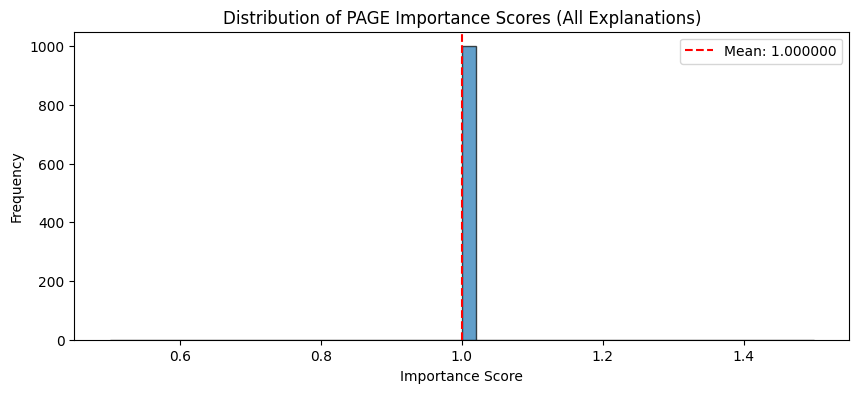

Score statistics:
  Min: 1.000000
  Max: 1.000000
  Mean: 1.000000
  Std: 0.000000
  Range: 0.000000


In [14]:
# Check importance score distribution across all explanations
all_scores = []
for exp in page_exp['explanations']:
    all_scores.extend(exp['importance_scores'].tolist())

plt.figure(figsize=(10, 4))
plt.hist(all_scores, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Importance Score')
plt.ylabel('Frequency')
plt.title('Distribution of PAGE Importance Scores (All Explanations)')
plt.axvline(x=np.mean(all_scores), color='r', linestyle='--', label=f'Mean: {np.mean(all_scores):.6f}')
plt.legend()
plt.show()

print(f'Score statistics:')
print(f'  Min: {np.min(all_scores):.6f}')
print(f'  Max: {np.max(all_scores):.6f}')
print(f'  Mean: {np.mean(all_scores):.6f}')
print(f'  Std: {np.std(all_scores):.6f}')
print(f'  Range: {np.max(all_scores) - np.min(all_scores):.6f}')

## 6. Load and Analyze PaGE-Link Explainer Results

PaGE-Link is a path-based GNN explanation method that:
- Learns edge masks to identify important edges
- Finds paths between head and tail nodes
- Uses path-based subgraph extraction (only edges on paths ≤ N hops)

In [ ]:
# Load PaGE-Link explanations
pagelink_path = DATA_DIR / 'pagelink_explanations.pkl'
if pagelink_path.exists():
    pagelink_exp = load_pickle_cpu(pagelink_path)
    
    print('PaGE-Link Explainer Results:')
    print(f'  Explainer type: {pagelink_exp["explainer_type"]}')
    print(f'  Num explanations: {pagelink_exp["num_explanations"]}')
    print()
    print('Parameters:')
    for k, v in pagelink_exp['params'].items():
        print(f'  {k}: {v}')
else:
    print(f'PaGE-Link results not found at {pagelink_path}')

In [ ]:
# Analyze PaGE-Link explanation structure
if 'pagelink_exp' in dir() and pagelink_exp['num_explanations'] > 0:
    exp = pagelink_exp['explanations'][0]
    print('PaGE-Link Explanation Structure:')
    print(f'  Keys: {list(exp.keys())}')
    print()
    for k, v in exp.items():
        if hasattr(v, 'shape'):
            print(f'  {k}: tensor shape={v.shape}, dtype={v.dtype}')
        elif isinstance(v, dict):
            print(f'  {k}: dict with {len(v)} keys: {list(v.keys())}')
        elif isinstance(v, list):
            print(f'  {k}: list with {len(v)} items')
            if len(v) > 0:
                print(f'       First item type: {type(v[0]).__name__}')
        else:
            print(f'  {k}: {type(v).__name__} = {v}')

In [ ]:
# Create summary DataFrame for PaGE-Link results
if 'pagelink_exp' in dir():
    pagelink_summary = []
    for i, exp in enumerate(pagelink_exp['explanations']):
        triple_info = exp['triple']
        subg = exp.get('subgraph_info', {})
        paths = exp.get('paths', [])
        edge_mask = exp.get('edge_mask')
        important_edges = exp.get('important_edges')
        
        # Get edge mask statistics if available
        if edge_mask is not None:
            mask_min = edge_mask.min().item()
            mask_max = edge_mask.max().item()
            mask_mean = edge_mask.mean().item()
            mask_std = edge_mask.std().item()
        else:
            mask_min = mask_max = mask_mean = mask_std = None
        
        pagelink_summary.append({
            'idx': i,
            'triple': triple_info['triple'],
            'head': triple_info['head_name'],
            'relation': triple_info['relation_name'],
            'tail': triple_info['tail_name'],
            'prediction_score': exp.get('prediction_score', None),
            'num_paths': len(paths),
            'subgraph_nodes': subg.get('num_nodes', None),
            'subgraph_edges': subg.get('num_edges', None),
            'mask_min': mask_min,
            'mask_max': mask_max,
            'mask_mean': mask_mean,
            'mask_std': mask_std,
            'has_error': 'error' in exp,
        })
    
    pagelink_df = pd.DataFrame(pagelink_summary)
    print(f"PaGE-Link Results Summary ({len(pagelink_df)} explanations):")
    print(f"  Successful: {(~pagelink_df['has_error']).sum()}")
    print(f"  Failed: {pagelink_df['has_error'].sum()}")
    print()
    pagelink_df

In [ ]:
# Visualize PaGE-Link edge mask distributions
if 'pagelink_exp' in dir():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Edge mask score distribution (all explanations)
    all_mask_scores = []
    for exp in pagelink_exp['explanations']:
        if exp.get('edge_mask') is not None:
            all_mask_scores.extend(exp['edge_mask'].tolist())
    
    if all_mask_scores:
        axes[0, 0].hist(all_mask_scores, bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].set_xlabel('Edge Mask Score (sigmoid)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of PaGE-Link Edge Mask Scores')
        axes[0, 0].axvline(x=np.mean(all_mask_scores), color='r', linestyle='--', 
                          label=f'Mean: {np.mean(all_mask_scores):.4f}')
        axes[0, 0].axvline(x=0.5, color='g', linestyle=':', label='Threshold: 0.5')
        axes[0, 0].legend()
    
    # 2. Number of paths found per triple
    successful_df = pagelink_df[~pagelink_df['has_error']]
    if len(successful_df) > 0:
        axes[0, 1].barh(range(len(successful_df)), successful_df['num_paths'])
        axes[0, 1].set_yticks(range(len(successful_df)))
        axes[0, 1].set_yticklabels([f"Triple {i+1}" for i in successful_df['idx']])
        axes[0, 1].set_xlabel('Number of Paths Found')
        axes[0, 1].set_title('Paths Found per Triple')
        axes[0, 1].invert_yaxis()
    
    # 3. Subgraph sizes
    if len(successful_df) > 0 and successful_df['subgraph_edges'].notna().any():
        axes[1, 0].barh(range(len(successful_df)), successful_df['subgraph_edges'])
        axes[1, 0].set_yticks(range(len(successful_df)))
        axes[1, 0].set_yticklabels([f"Triple {i+1}" for i in successful_df['idx']])
        axes[1, 0].set_xlabel('Number of Edges in Subgraph')
        axes[1, 0].set_title('Path-based Subgraph Sizes')
        axes[1, 0].invert_yaxis()
    
    # 4. Edge mask statistics per triple
    if len(successful_df) > 0 and successful_df['mask_mean'].notna().any():
        x = range(len(successful_df))
        axes[1, 1].errorbar(x, successful_df['mask_mean'], 
                           yerr=successful_df['mask_std'], 
                           fmt='o', capsize=5)
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels([f"T{i+1}" for i in successful_df['idx']])
        axes[1, 1].set_xlabel('Triple')
        axes[1, 1].set_ylabel('Edge Mask Score')
        axes[1, 1].set_title('Edge Mask Statistics per Triple (mean ± std)')
        axes[1, 1].axhline(y=0.5, color='g', linestyle=':', label='Threshold: 0.5')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    if all_mask_scores:
        print(f'\nEdge Mask Score Statistics (all explanations):')
        print(f'  Count: {len(all_mask_scores):,}')
        print(f'  Min: {np.min(all_mask_scores):.4f}')
        print(f'  Max: {np.max(all_mask_scores):.4f}')
        print(f'  Mean: {np.mean(all_mask_scores):.4f}')
        print(f'  Std: {np.std(all_mask_scores):.4f}')
        print(f'  % above 0.5: {100 * np.mean(np.array(all_mask_scores) > 0.5):.1f}%')
        print(f'  % above 0.7: {100 * np.mean(np.array(all_mask_scores) > 0.7):.1f}%')
        print(f'  % above 0.9: {100 * np.mean(np.array(all_mask_scores) > 0.9):.1f}%')

In [ ]:
def analyze_pagelink_explanation(exp_idx, pagelink_exp, idx_to_entity, idx_to_relation):
    """Analyze a single PaGE-Link explanation in detail."""
    exp = pagelink_exp['explanations'][exp_idx]
    
    triple = exp['triple']
    print(f"{'='*80}")
    print(f"PaGE-Link Explanation for Triple {exp_idx + 1}")
    print(f"{'='*80}")
    print(f"Triple: {triple['triple']}")
    print(f"Head: {triple['head_name']} (idx: {triple['head_idx']})")
    print(f"Relation: {triple['relation_name']} (idx: {triple['relation_idx']})")
    print(f"Tail: {triple['tail_name']} (idx: {triple['tail_idx']})")
    print()
    
    # Check for errors
    if 'error' in exp:
        print(f"ERROR: {exp['error']}")
        return None
    
    # Prediction info
    pred = exp.get('prediction_score')
    if pred is not None:
        print(f"Prediction score: {pred:.4f}")
    
    # Subgraph info
    subg = exp.get('subgraph_info', {})
    print(f"Subgraph: {subg.get('num_nodes', 'N/A')} nodes, {subg.get('num_edges', 'N/A')} edges")
    print()
    
    # Paths found
    paths = exp.get('paths', [])
    print(f"Number of paths found: {len(paths)}")
    print()
    
    if paths:
        print("Top Explanation Paths:")
        for i, path in enumerate(paths[:10]):  # Show top 10 paths
            path_str_parts = []
            for step in path:
                if len(step) == 3:
                    src, rel, dst = step
                    src_name = idx_to_entity.get(src, f"node_{src}")
                    dst_name = idx_to_entity.get(dst, f"node_{dst}")
                    rel_name = idx_to_relation.get(rel, f"rel_{rel}")
                    path_str_parts.append(f"{src_name} --[{rel_name}]--> {dst_name}")
            
            path_len = len(path)
            print(f"  Path {i+1} ({path_len}-hop):")
            for part in path_str_parts:
                print(f"    {part}")
            print()
    
    # Important edges - list of dicts with keys: 'src', 'rel', 'dst', 'weight'
    important_edges = exp.get('important_edges')
    if important_edges is not None and len(important_edges) > 0:
        print(f"\nTop Important Edges (by learned mask):")
        
        for i, edge_info in enumerate(important_edges[:10]):  # Show top 10
            src = edge_info['src']
            dst = edge_info['dst']
            rel = edge_info['rel']
            score = edge_info['weight']
            
            src_name = idx_to_entity.get(src, f"node_{src}")
            dst_name = idx_to_entity.get(dst, f"node_{dst}")
            rel_name = idx_to_relation.get(rel, f"rel_{rel}")
            
            print(f"  {i+1}. {src_name} --[{rel_name}]--> {dst_name}  (score: {score:.4f})")
    
    return exp

# Analyze first PaGE-Link explanation
if 'pagelink_exp' in dir() and pagelink_exp['num_explanations'] > 0:
    analyze_pagelink_explanation(0, pagelink_exp, idx_to_entity, idx_to_relation)

In [ ]:
# Analyze all PaGE-Link explanations
if 'pagelink_exp' in dir():
    print("\n" + "="*80)
    print("SUMMARY OF ALL PaGE-Link EXPLANATIONS")
    print("="*80 + "\n")
    
    for i in range(len(pagelink_exp['explanations'])):
        analyze_pagelink_explanation(i, pagelink_exp, idx_to_entity, idx_to_relation)
        print("\n" + "-"*80 + "\n")

In [ ]:
# Analyze path length distribution
if 'pagelink_exp' in dir():
    path_lengths = []
    for exp in pagelink_exp['explanations']:
        if 'error' not in exp:
            for path in exp.get('paths', []):
                path_lengths.append(len(path))
    
    if path_lengths:
        plt.figure(figsize=(10, 4))
        
        # Count path lengths
        length_counts = pd.Series(path_lengths).value_counts().sort_index()
        
        plt.bar(length_counts.index, length_counts.values, edgecolor='black', alpha=0.7)
        plt.xlabel('Path Length (number of hops)')
        plt.ylabel('Count')
        plt.title('Distribution of Explanation Path Lengths')
        plt.xticks(length_counts.index)
        
        # Add percentages
        total = len(path_lengths)
        for length, count in length_counts.items():
            pct = 100 * count / total
            plt.annotate(f'{pct:.1f}%', xy=(length, count), ha='center', va='bottom')
        
        plt.show()
        
        print(f'\nPath Length Statistics:')
        print(f'  Total paths: {len(path_lengths)}')
        print(f'  Distribution:')
        for length, count in length_counts.items():
            print(f'    {length}-hop: {count} ({100*count/total:.1f}%)')

## 7. Comparison: PAGE vs PaGE-Link

Key differences between the two explainers:

| Aspect | PAGE | PaGE-Link |
|--------|------|-----------|
| **Approach** | VGAE reconstruction | Learned edge masks |
| **Training** | Amortized (train once) | Per-instance optimization |
| **Output** | Edge importance matrix | Paths + edge masks |
| **Subgraph** | k-hop neighborhood | Path-based (edges on valid paths) |
| **Interpretability** | Edge scores | Explicit paths from head to tail |

In [ ]:
# Compare subgraph sizes between PAGE and PaGE-Link
if 'page_df' in dir() and 'pagelink_df' in dir():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Nodes comparison
    x = np.arange(min(len(page_df), len(pagelink_df)))
    width = 0.35
    
    page_nodes = page_df['subgraph_nodes'].values[:len(x)]
    pagelink_nodes = pagelink_df['subgraph_nodes'].dropna().values[:len(x)]
    
    if len(pagelink_nodes) > 0:
        axes[0].bar(x - width/2, page_nodes, width, label='PAGE', alpha=0.7)
        axes[0].bar(x + width/2, pagelink_nodes[:len(x)], width, label='PaGE-Link', alpha=0.7)
        axes[0].set_xlabel('Triple Index')
        axes[0].set_ylabel('Number of Nodes')
        axes[0].set_title('Subgraph Size Comparison: Nodes')
        axes[0].legend()
        axes[0].set_xticks(x)
    
    # Edges comparison
    page_edges = page_df['subgraph_edges'].values[:len(x)]
    pagelink_edges = pagelink_df['subgraph_edges'].dropna().values[:len(x)]
    
    if len(pagelink_edges) > 0:
        axes[1].bar(x - width/2, page_edges, width, label='PAGE', alpha=0.7)
        axes[1].bar(x + width/2, pagelink_edges[:len(x)], width, label='PaGE-Link', alpha=0.7)
        axes[1].set_xlabel('Triple Index')
        axes[1].set_ylabel('Number of Edges')
        axes[1].set_title('Subgraph Size Comparison: Edges')
        axes[1].legend()
        axes[1].set_xticks(x)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison statistics
    print("\nSubgraph Size Comparison:")
    print(f"  PAGE average nodes: {page_df['subgraph_nodes'].mean():.0f}")
    print(f"  PAGE average edges: {page_df['subgraph_edges'].mean():.0f}")
    if pagelink_df['subgraph_nodes'].notna().any():
        print(f"  PaGE-Link average nodes: {pagelink_df['subgraph_nodes'].mean():.0f}")
        print(f"  PaGE-Link average edges: {pagelink_df['subgraph_edges'].mean():.0f}")
        
        # Reduction ratio
        avg_reduction = 1 - (pagelink_df['subgraph_edges'].mean() / page_df['subgraph_edges'].mean())
        print(f"\n  PaGE-Link edge reduction: {100*avg_reduction:.1f}% fewer edges on average")